In [1]:
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

# define the answer key which maps the question number
# to the correct answer
ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}

In [2]:
# load the image, convert it to grayscale, blur it
# slightly, then find edges
image = cv2.imread('test_image.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 75, 200)

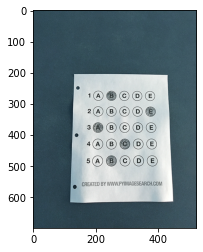

In [3]:
plt.imshow(image)

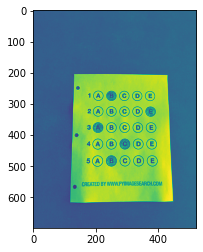

In [4]:
plt.imshow(gray)

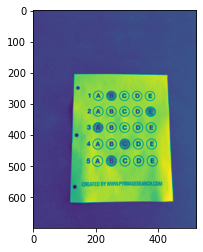

In [5]:
plt.imshow(blurred)

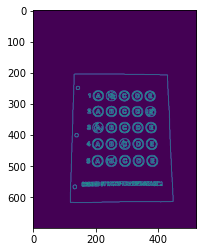

In [6]:
plt.imshow(edged)

In [7]:
# find contours in the edge map, then initialize
# the contour that corresponds to the document
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
docCnt = None
# ensure that at least one contour was found
if len(cnts) > 0:
    # sort the contours according to their size in
    # descending order
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    # loop over the sorted contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        # if our approximated contour has four points,
        # then we can assume we have found the paper
        if len(approx) == 4:
            docCnt = approx
            break

In [8]:
docCnt

array([[[131, 206]],

       [[119, 617]],

       [[448, 614]],

       [[430, 208]]], dtype=int32)

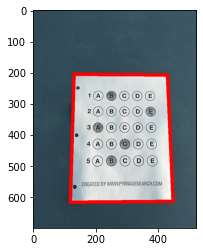

In [9]:
plt.imshow(cv2.polylines(image.copy(),[docCnt],True,(255,0,0), 10))

In [10]:
# apply a four point perspective transform to both the
# original image and grayscale image to obtain a top-down
# birds eye view of the paper
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))

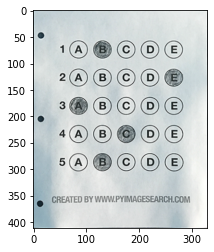

In [11]:
plt.imshow(paper)

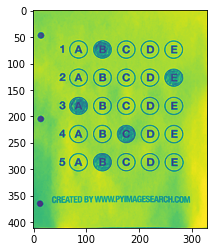

In [12]:
plt.imshow(warped)

In [13]:
# apply Otsu's thresholding method to binarize the warped
# piece of paper
thresh = cv2.threshold(warped, 0, 255,
                       cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

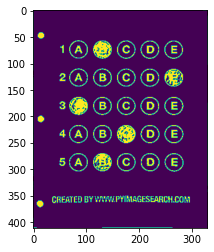

In [14]:
plt.imshow(thresh)

In [15]:
# find contours in the thresholded image, then initialize
# the list of contours that correspond to questions
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
questionCnts = []
# loop over the contours
for c in cnts:
    # compute the bounding box of the contour, then use the
    # bounding box to derive the aspect ratio
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    # in order to label the contour as a question, region
    # should be sufficiently wide, sufficiently tall, and
    # have an aspect ratio approximately equal to 1
#     print(w, h, ar)
    if w >= 20 and h >= 20 and ar >= 0.9 and ar <= 1.1:
#     if ar >= 0.9 and ar <= 1.1:
        questionCnts.append(c)

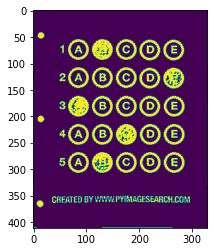

In [16]:
new_image = thresh.copy()

for c in questionCnts:
    (x, y, w, h) = cv2.boundingRect(c)
#     new_image=cv2.rectangle(new_image,(x,y),(x+w,y+h),(255,0,0),3)
    new_image = cv2.circle(new_image, (int(x+w/2), int(y+h/2)), int((w+h)/4), (255, 0, 0), 3)
plt.imshow(new_image)

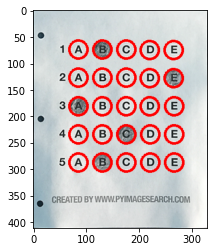

In [17]:
new_image = paper.copy()

for c in questionCnts:
    (x, y, w, h) = cv2.boundingRect(c)
#     new_image=cv2.rectangle(new_image,(x,y),(x+w,y+h),(255,0,0),3)
    new_image = cv2.circle(new_image, (int(x+w/2), int(y+h/2)), int((w+h)/4), (255, 0, 0), 3)
plt.imshow(new_image)

In [18]:
# sort the question contours top-to-bottom, then initialize
# the total number of correct answers
questionCnts = contours.sort_contours(questionCnts,
    method="top-to-bottom")[0]
correct = 0
# each question has 5 possible answers, to loop over the
# question in batches of 5
for (q, i) in enumerate(np.arange(0, len(questionCnts), 5)):
    # sort the contours for the current question from
    # left to right, then initialize the index of the
    # bubbled answer
    cnts = contours.sort_contours(questionCnts[i:i + 5])[0]
    bubbled = None
    # loop over the sorted contours
    for (j, c) in enumerate(cnts):
        # construct a mask that reveals only the current
        # "bubble" for the question
        mask = np.zeros(thresh.shape, dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)
        # apply the mask to the thresholded image, then
        # count the number of non-zero pixels in the
        # bubble area
        mask = cv2.bitwise_and(thresh, thresh, mask=mask)
        total = cv2.countNonZero(mask)
        # if the current total has a larger number of total
        # non-zero pixels, then we are examining the currently
        # bubbled-in answer
        if bubbled is None or total > bubbled[0]:
            bubbled = (total, j)
    # initialize the contour color and the index of the
    # *correct* answer
    color = (255, 0, 0)
    k = ANSWER_KEY[q]
    # check to see if the bubbled answer is correct
    if k == bubbled[1]:
        color = (0, 255, 0)
        correct += 1
    # draw the outline of the correct answer on the test
    cv2.drawContours(paper, [cnts[k]], -1, color, 3)

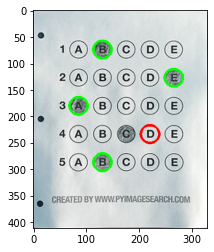

In [19]:
plt.imshow(paper)

In [20]:
# grab the test taker
score = (correct / 5.0) * 100
print("[INFO] score: {:.2f}%".format(score))
cv2.putText(paper, "{:.2f}%".format(score), (10, 30),
    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

[INFO] score: 80.00%


array([[[134, 157, 170],
        [228, 249, 250],
        [217, 239, 243],
        ...,
        [144, 157, 166],
        [152, 162, 169],
        [129, 139, 144]],

       [[121, 143, 153],
        [222, 240, 243],
        [216, 235, 238],
        ...,
        [241, 243, 244],
        [245, 246, 247],
        [237, 240, 239]],

       [[103, 125, 133],
        [206, 225, 231],
        [204, 221, 226],
        ...,
        [247, 249, 248],
        [253, 254, 254],
        [230, 235, 234]],

       ...,

       [[140, 164, 176],
        [174, 201, 213],
        [156, 182, 194],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [198, 196, 196]],

       [[157, 181, 193],
        [191, 219, 231],
        [173, 201, 212],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [230, 226, 229]],

       [[ 90, 110, 123],
        [120, 140, 156],
        [111, 131, 145],
        ...,
        [206, 200, 202],
        [202, 198, 202],
        [179, 176, 181]]

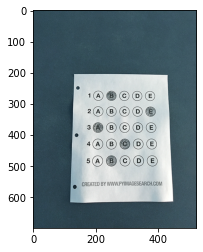

In [21]:
plt.imshow(image)

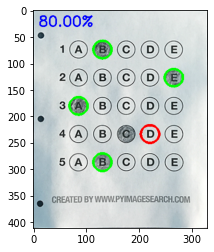

In [22]:
plt.imshow(paper)

In [23]:
!python experiment.py -i test_image.png

[INFO] score: 80.00%
